# Spatial Weights: Case Study

- [Introduction](#Introduction)
- [Data](#Data)
- [TAZ Contiguity](#Construct-a-Rook-contiguity-weight)
- [Counties as sets](#Counties-as-sets)
- [Block weights](#Block-weights)
- [Intersection weights](#Intersection-weights)

## Introduction
This notebook illustrates the use of PySAL weights in preparing input to a
spatial optimization model. It makes use of the `set-theoretic` functionality
that the weights class affords.

The researcher is building an optimization model to partition traffic analysis
zones (TAZs) subject to contiguity constraints and a boundary condition, such
that flows between TAZs assigned to the same group are maximized, but flows
cannot cross specified boundaries. The problem facing the research is to develop
a representation of neighbor relations as input to the spatial optimization
model.

## Data
The data under consideration is a set of *Traffic Analysis Zones* (TAZs) in Southern California.
We first read these in and visualize the context:

In [1]:
import numpy as np
import libpysal 
import random as rdm
import geopandas as gpd
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
shp = gpd.read_file(libpysal.examples.get_path("taz.shp"))
shp.head()

,AREA,PERIMETER,CNTY,RSA,AIRDB,TAZ2K,SQ_MILE,ACRE,NEWSEQ,CSA,CSA_NEW,SQMI_TAZ,TAZ_NUM,CountyFIPS,geometry
0,3.063184e+09,243171.125,5,31,9,501030005,1182.68,756920.29,3884,900,0,1182.697393,501030005,5,"POLYGON ((559589.3380988396 3961300.566593952,..."
1,3.523131e+09,279249.313,5,31,9,500890100,1360.27,870578.15,3878,900,0,1360.283134,500890100,5,"POLYGON ((505502.4600336744 3961256.872095753,..."
2,5.587425e+09,319885.094,5,31,9,501030001,2157.29,1380675.24,3881,900,0,2157.308384,501030001,5,"POLYGON ((505502.4600336744 3961256.872095753,..."
3,6.799230e+09,376757.563,5,31,9,501030000,2625.13,1680092.40,3885,900,0,2625.186791,501030000,5,"POLYGON ((645688.6822469186 3941581.368372787,..."
4,2.598151e+09,270201.500,5,32,7,501160000,1003.14,642015.54,3956,0,256,1003.147789,501160000,5,"POLYGON ((504605.1814501855 3903234.960551923,..."


(247555.4738695356, 788748.4256152901, 3591645.390108616, 3981320.303239247)

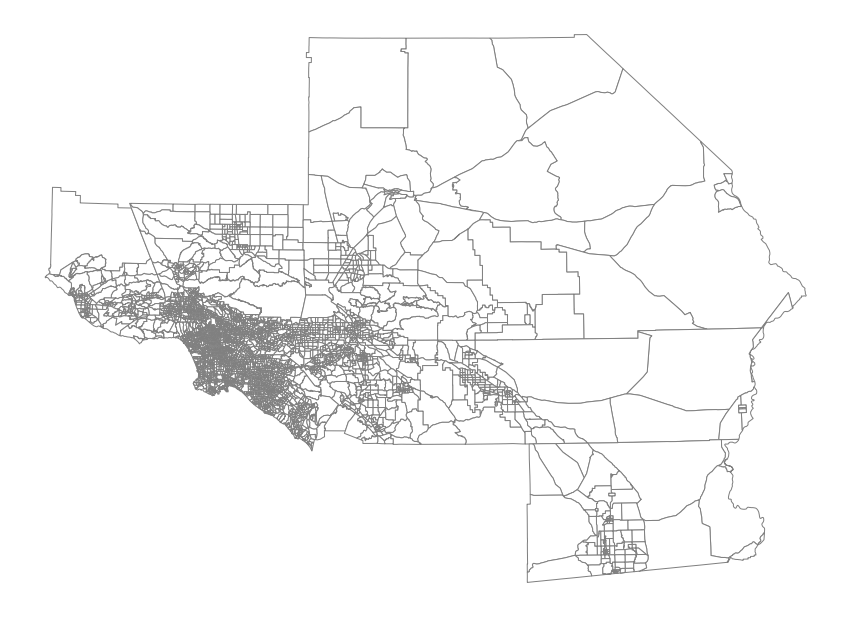

In [3]:
shp.plot(figsize=(15,15),color='white', edgecolor='grey')
plt.axis('off')

### Construct a Rook contiguity weight
The researcher first needs to define the adjacency relations between the TAZs. Here the *rook* criterion is used:

In [4]:
wrook = libpysal.weights.Rook.from_dataframe(shp)

/home/serge/anaconda3/envs/pysalworkshop/lib/python3.6/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [5]:
def w2line_graph(w, shp):
    segments = []
    centroids = shp.centroid.values
    for i in w.id2i:
        origin = np.array(centroids[i].coords)[0] 
        for j in w.neighbors[i]:
            dest = np.array(centroids[j].coords)[0]
            ij = [i,j]
            ij.sort()
            segments.append([origin, dest])

    return segments    

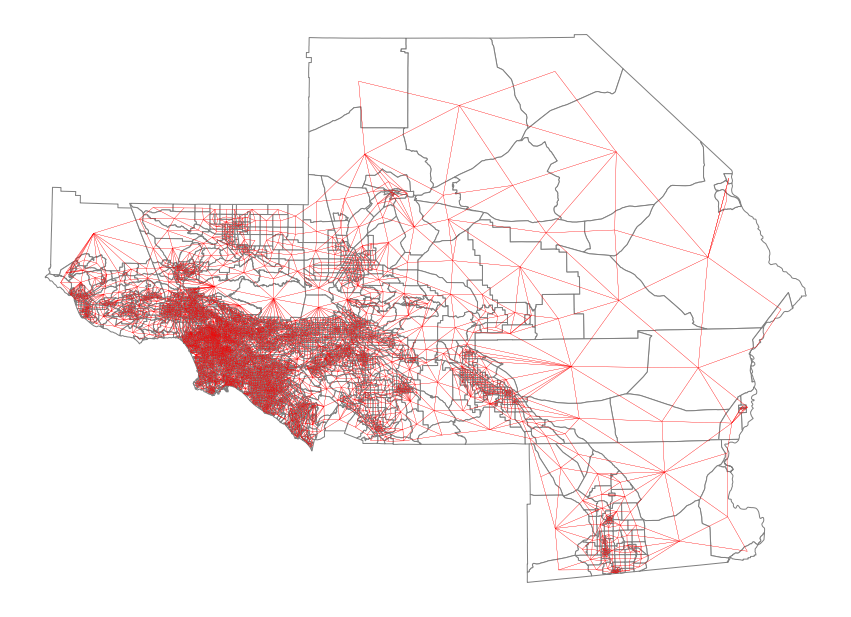

In [6]:
segs = w2line_graph(wrook, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

We can zoom into a more dense area of the region by setting the view limits on the axis object:

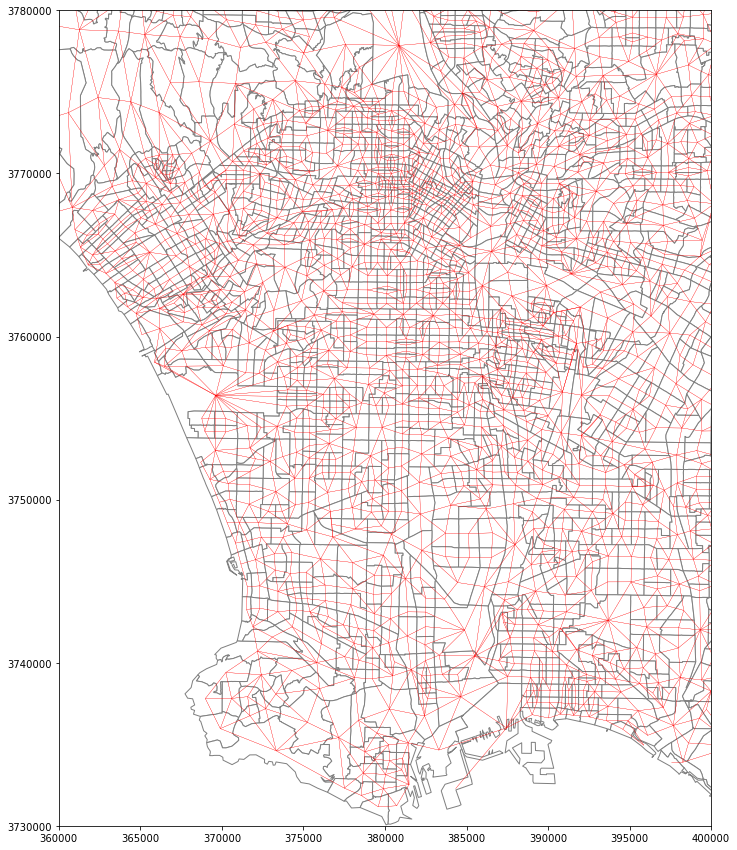

In [7]:
segs = w2line_graph(wrook, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
_ = ax.set_xlim(360000, 400000)
_ = ax.set_ylim(3730000, 3780000)

#ax.set_axis_off()

Note that we have commented out the call to turn the axis off. 

## Counties as sets
The county boundaries are going to play the role of the sets. 

In [8]:
shp["CNTY"].describe()

count    4109.000000
mean        2.865904
std         1.266095
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         6.000000
Name: CNTY, dtype: float64

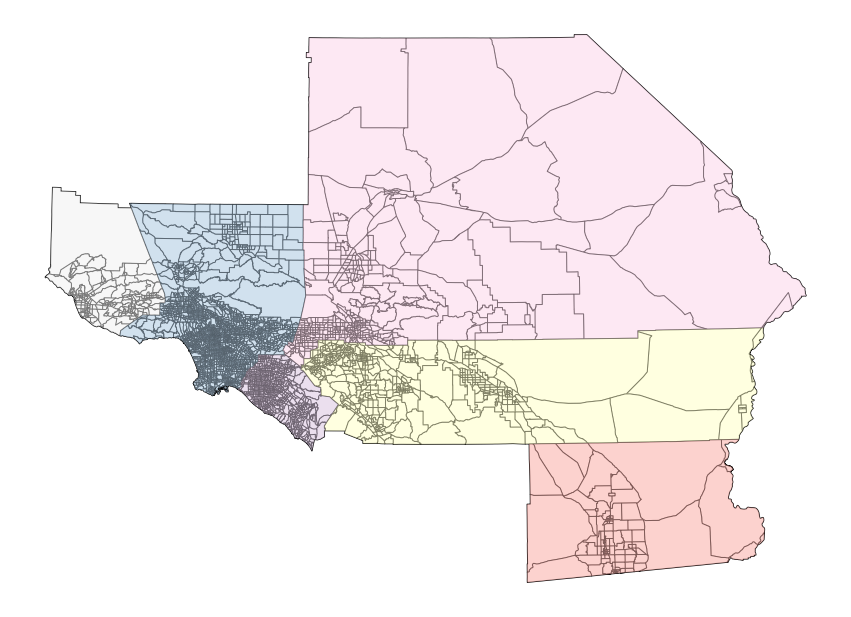

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax,color='white', edgecolor='black')
shp.plot(column="CNTY", ax=ax, categorical=True,cmap="Pastel1",alpha=0.6)
ax.set_axis_off()

## Block weights

As we learned previously, block weights use a membership variable that partitions the observations into exhaustive and mutually exclusive groups. All members belonging to the same group are treated as pair-wise neighbors.

In [10]:
libpysal.weights.block_weights?

Given this, we can use the `CNTY` attribute as our membership variable:

In [11]:
wb = libpysal.weights.block_weights(shp["CNTY"])

/home/serge/anaconda3/envs/pysalworkshop/lib/python3.6/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


Notice the warning about 6 disconected components. This is definitely a feature here, as the model precludes TAZs from different counties forming a neighbor pair.

We can examine the connectivity graph:

In [12]:
segs = w2line_graph(wb, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

KeyboardInterrupt: 

and we see that it is much denser than the simple rook contiguity graph.

## Intersection weights

In [ ]:
wint = libpysal.weights.w_intersection(wb, wrook)

In [ ]:
segs = w2line_graph(wint, shp)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax, color='white', edgecolor='grey')
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
shp.plot(ax=ax,color='white', edgecolor='black')
shp.plot(column="CNTY", ax=ax, categorical=True,cmap="Pastel1",alpha=0.6)
segs_plot = LineCollection(np.array(segs),colors="red")
segs_plot.set_linewidth(0.20)
ax.add_collection(segs_plot)
ax.set_axis_off()